In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import Counter
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from statsmodels.graphics.mosaicplot import mosaic
import seaborn as sns
from colour import Color

### Loading the dataset from json format

In [2]:
def iter_dataset():
    with open(filename,'rt') as fid:
        for line in fid:
            example = json.loads(line)
            yield(example['cms_prescription_counts'],example['provider_variables'])
            

The data is in json format. The data is saved as a list of tuples. Each tuple consists of two dictionaries. The first dictionary provides information about the prescriptions and their counts, and the second dictionary contain information about prescription provider. 

I am analyzing only those practitioners who have prescribed more than 50 drugs.

In [3]:
filename = 'roam_prescription_based_prediction.jsonl'
data = [(phi_dict, y_dict) for phi_dict, y_dict in iter_dataset()
       if len(phi_dict)>50]
print ('Example data :\n')
data[0]

Example data :



({'ABILIFY': 11,
  'ALLOPURINOL': 86,
  'ALPRAZOLAM': 45,
  'AMLODIPINE BESYLATE': 175,
  'AMLODIPINE BESYLATE-BENAZEPRIL': 12,
  'ATENOLOL': 62,
  'ATENOLOL-CHLORTHALIDONE': 53,
  'ATORVASTATIN CALCIUM': 19,
  'AZITHROMYCIN': 18,
  'BENAZEPRIL HCL': 11,
  'BUMETANIDE': 53,
  'BYSTOLIC': 14,
  'CALCITRIOL': 79,
  'CALCIUM ACETATE': 85,
  'CARISOPRODOL': 40,
  'CARVEDILOL': 36,
  'CIPROFLOXACIN HCL': 19,
  'CLONIDINE HCL': 43,
  'CLOPIDOGREL': 22,
  'DIAZEPAM': 24,
  'DIOVAN': 20,
  'DOXAZOSIN MESYLATE': 26,
  'FENOFIBRATE': 14,
  'FUROSEMIDE': 162,
  'GABAPENTIN': 35,
  'GLYBURIDE': 16,
  'HYDRALAZINE HCL': 50,
  'HYDROCHLOROTHIAZIDE': 59,
  'HYDROCODONE-ACETAMINOPHEN': 64,
  'IRBESARTAN': 11,
  'ISOSORBIDE MONONITRATE ER': 13,
  'KLOR-CON M10': 20,
  'LABETALOL HCL': 28,
  'LANTUS': 20,
  'LEVOTHYROXINE SODIUM': 12,
  'LISINOPRIL': 44,
  'LISINOPRIL-HYDROCHLOROTHIAZIDE': 19,
  'LOSARTAN POTASSIUM': 41,
  'LOSARTAN-HYDROCHLOROTHIAZIDE': 14,
  'LOVASTATIN': 11,
  'MEGESTROL ACETATE': 11

Let's take a look at the specialites of the practitioners. We will futher filter the dataset based on this attribute. I will study only those groups where more than 50 practitioners are available to have enough data for modeling later.

In [4]:
specialties = Counter([y_dict['specialty'] for phi_dict,y_dict in data])
print ("Total specialties in the dataset = {}".format(len(specialties)))

#Selecting specialties with >=50 practitioners
specialties = set([s for s,c in specialties.items() if c>=50])

#Final dataset contains practitioners with atleast >=50 practitioners per
#specialty and each practitioner having prescribed >50 drugs

data = [(phi,ys) for phi,ys in data if ys['specialty'] in specialties]

Total specialties in the dataset = 113


## Descriptive Statistics

For this analysis, we will use each drug name as a feature. Thus our input for each practitioner will consist of a vector where the prescribed drugs are the features, and the values correspond to number of times each drug is prescribed. The targets will consist of the all the information gathered about the practitioner.

In [5]:
feats, ys = zip(*data)
ys = pd.DataFrame(list(ys))#preparing targets

vectorizer = DictVectorizer(sparse=True)
X = vectorizer.fit_transform(feats)
X = TfidfTransformer().fit_transform(X)#preparing features


Let's look the gender distribution of the practitioners.

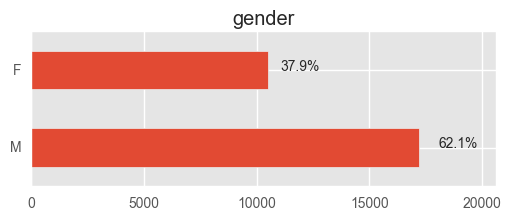

In [6]:
plt.style.use('ggplot')
gender_counts = ys['gender'].value_counts()
perc_gender = gender_counts.values/gender_counts.values.sum()

fig_gender = plt.figure(figsize=(6,2))
ax = plt.subplot()
gender_counts.plot(kind='barh',title=ys['gender'].name,figsize=(6,2),ax=ax)
for i,val in enumerate(gender_counts.values):
    ax.text(val*1.05,i,'{:2.1%}'.format(perc_gender[i]))

ax.set_xlim((0,max(gender_counts.values)*1.2))
plt.show()
fig_gender.savefig('gender_distribution.png',bbox_inches='tight')

Let's look at the distribution of the practioners based on the regions

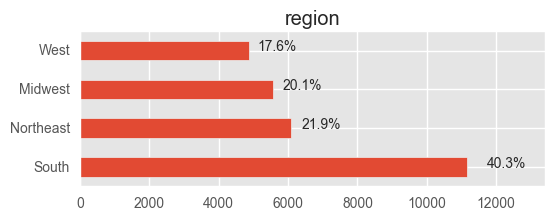

In [7]:
region_counts = ys['region'].value_counts()
perc_region = region_counts.values/region_counts.values.sum()

fig_region = plt.figure(figsize=(6,2))
ax = plt.subplot()
region_counts.plot(kind='barh',title=ys['region'].name,figsize=(6,2),ax=ax)

for i,val in enumerate(region_counts.values):
    ax.text(val*1.05,i,'{:2.1%}'.format(perc_region[i]))
    
ax.set_xlim((0,max(region_counts.values)*1.2))
plt.show()
fig_region.savefig('region_distribution.png',bbox_inches='tight')

Let's look at the how the practioners are distributed based on their specialty.

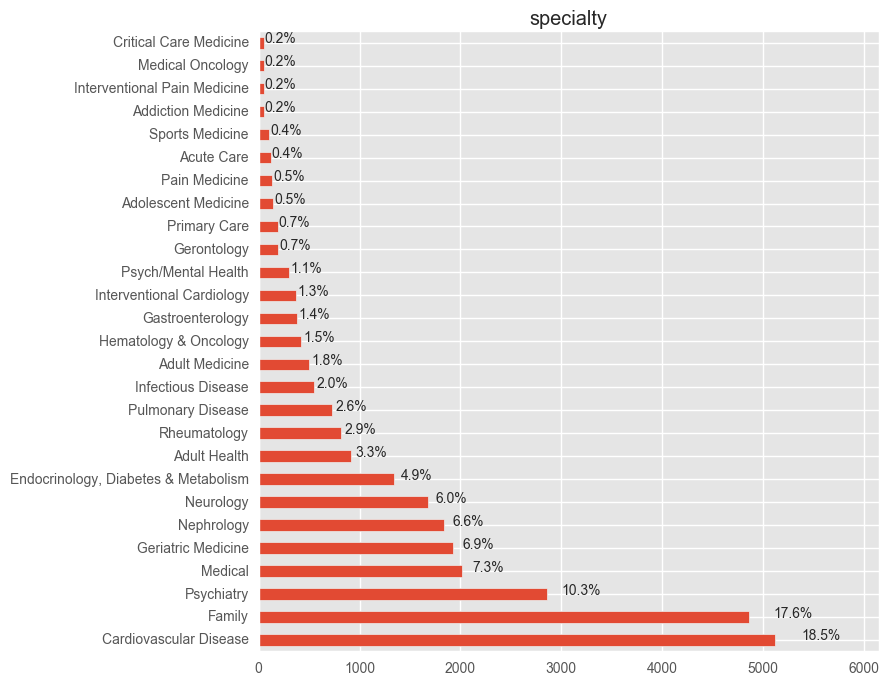

In [8]:
specialty_counts = ys['specialty'].value_counts()
perc_specialty = specialty_counts.values/specialty_counts.values.sum()

fig_specialty = plt.figure(figsize=(8,8))
ax = plt.subplot()
specialty_counts.plot(kind='barh',title=ys['specialty'].name,figsize=(8,8),ax=ax)

for i,val in enumerate(specialty_counts.values):
    ax.text(val*1.05,i,'{:2.1%}'.format(perc_specialty[i]))
    
ax.set_xlim((0,max(specialty_counts.values)*1.2))
plt.show()
fig_specialty.savefig('specialty_distribution.png',bbox_inches='tight')

In [9]:
gender = ys['gender']
spec = ys['specialty']
region = ys['region']

I am now trying to check for subdistributions with the category. For example, let's check if there seems to be a trend between the specialty and gender. In other words, maybe there are some specialties that are prefered by Males and some others that are prefered by Females.

In this case, I limit my analysis to only to specialties that have >= 1500 practitioners

In [10]:
spec_subset_1 = [s for s,c in specialty_counts.items() if c>=1500]
spec = ys['specialty'][ys['specialty'].isin(spec_subset_1)]


### Gender vs Specialty

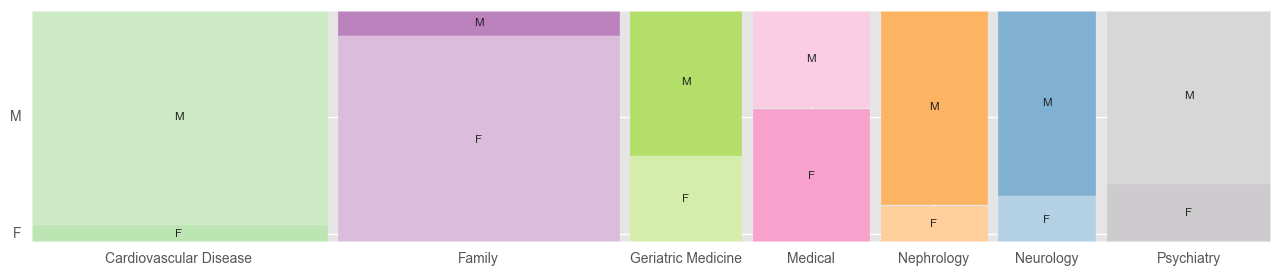

In [11]:
x_gender_spec = pd.crosstab(gender,spec).unstack()
lab = (lambda key:key[1])
colors = sns.color_palette('Set3_r',n_colors=10).as_hex()

props = lambda key:{'color': str(Color(colors[spec_subset_1.index(key[0])])) if key[1]=='M' 
                   else str(Color(colors[spec_subset_1.index(key[0])],luminance=0.8))}

fig_gender_spec,_ = mosaic(x_gender_spec,labelizer=lab,gap=0.01,properties=props)

fig_gender_spec.set_figwidth(16)
fig_gender_spec.set_figheight(3)
plt.show()

Based on the plot above it seems that there is gender preference in case of some specialties.
Let's check this for less popular specialties.

In [12]:
spec_subset_2 = [s for s,c in specialty_counts.items() if (c<=1500 and c>=300)]
spec = ys['specialty'][ys['specialty'].isin(spec_subset_2)]


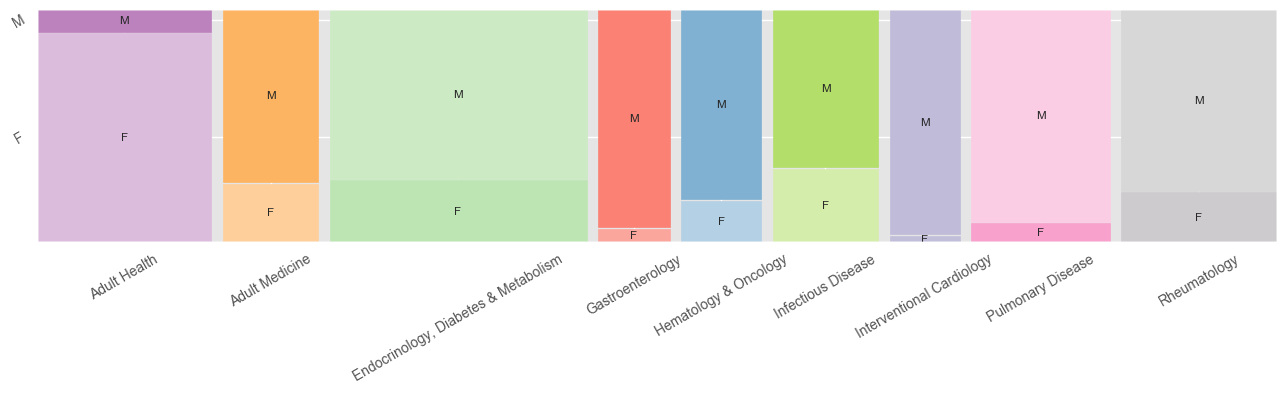

In [13]:
x_gender_spec = pd.crosstab(gender,spec).unstack()
lab = (lambda key:key[1])
colors = sns.color_palette('Set3_r',n_colors=10).as_hex()

props = lambda key:{'color': str(Color(colors[spec_subset_2.index(key[0])])) if key[1]=='M'
                    else str(Color(colors[spec_subset_2.index(key[0])],luminance=0.8))}

fig_gender_spec,_ = mosaic(x_gender_spec,labelizer=lab,gap=0.01,properties=props,label_rotation=30)

fig_gender_spec.set_figwidth(16)
fig_gender_spec.set_figheight(3)
plt.show()

Again there are some specialties where the most of the practitioners are males.

In [14]:
spec_subset_3 = [s for s,c in specialty_counts.items() if c<300]
spec = ys['specialty'][ys['specialty'].isin(spec_subset_3)]

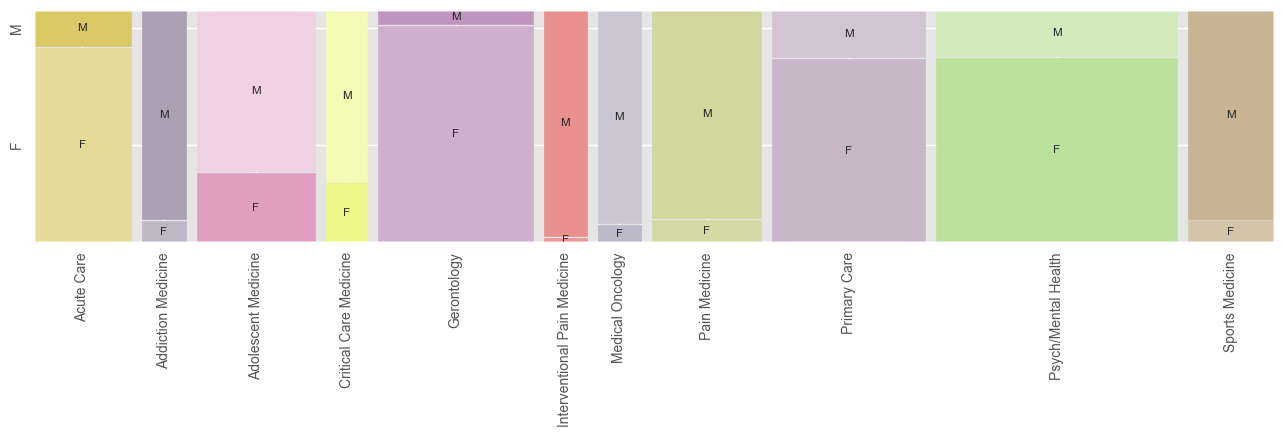

In [15]:
x_gender_spec = pd.crosstab(gender,spec).unstack()
lab = (lambda key:key[1])
colors = sns.color_palette('Set3_r',n_colors=11).as_hex()

props = lambda key:{'color': str(Color(colors[spec_subset_3.index(key[0])])) if key[1]=='M'
                    else str(Color(colors[spec_subset_3.index(key[0])],luminance=0.75))}

fig_gender_spec,_ = mosaic(x_gender_spec,labelizer=lab,gap=0.01,properties=props,label_rotation=90)

fig_gender_spec.set_figwidth(16)
fig_gender_spec.set_figheight(3)
plt.show()

Here Acute Care, Geontology, Primary Care and Psych/Mental Health have mostly Female practitioners whereas the other specialties have mostly Male practitioners.

#### Based on the observations above it seems like there is some correlation  between the gender and the specialty of the practitioner.

### Gender vs Years Practicing

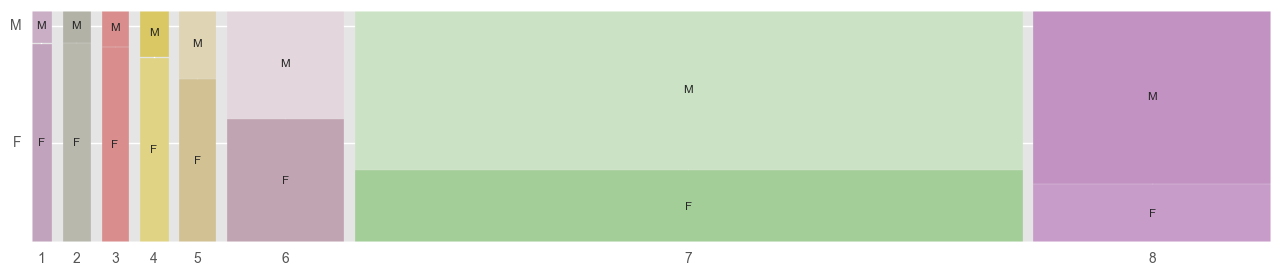

In [19]:
years = ys['years_practicing']
x_gender_years = pd.crosstab(gender,years).unstack()
lab = (lambda key:key[1])
colors = sns.color_palette('Set3_r',n_colors=9).as_hex()

props = lambda key:{'color': str(Color(colors[years.value_counts().index.tolist().index(int(key[0]))])) if key[1]=='M'
                    else str(Color(colors[years.value_counts().index.tolist().index(int(key[0]))],luminance=0.7))}

fig_gender_years,_ = mosaic(x_gender_years,labelizer=lab,gap=0.01,properties=props)

fig_gender_years.set_figwidth(16)
fig_gender_years.set_figheight(3)
plt.show()

It seems interesting that young practitioners are mostly Females and as that with increase in the years of practice  there are more Male practitioners.

### Gender vs Region

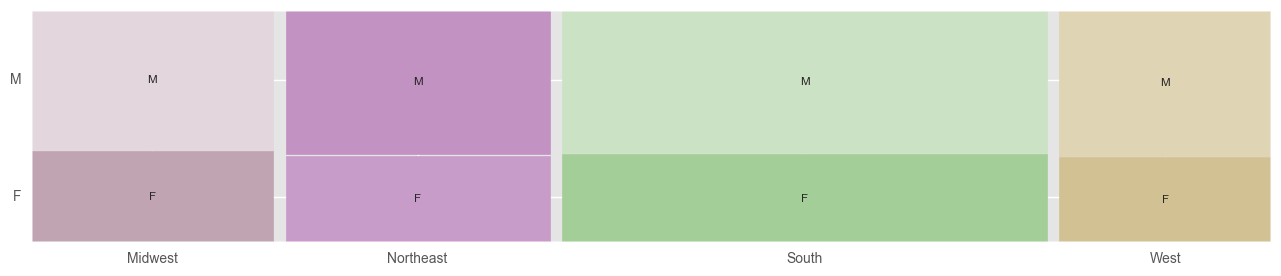

In [20]:
x_gender_region = pd.crosstab(gender,region).unstack()
lab = (lambda key:key[1])
colors = sns.color_palette('Set3_r',n_colors=9).as_hex()

props = lambda key:{'color': str(Color(colors[region.value_counts().index.tolist().index(key[0])])) if key[1]=='M'
                    else str(Color(colors[region.value_counts().index.tolist().index(key[0])],luminance=0.7))}

fig_gender_region,_ = mosaic(x_gender_region,labelizer=lab,gap=0.01,properties=props)

fig_gender_region.set_figwidth(16)
fig_gender_region.set_figheight(3)
plt.show()

